In [1]:
import sys
import os

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid', {'axes.grid': False})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'
model_cfg = '../configs/model_cfgs/pipeline2_rgbspec_san19pairfreeze_actreggru_halluconvlstm.yaml'
weight = '../saved_models/san19freeze_halluconvlstm_actreggru/dim32_layer1_nsegment10/epoch_00049.model'
model_cfg_mod = {'num_segments': 10, 'hallu_model_cfg': 'exp_cfgs/haluconvlstm_32_1.yaml'}

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_flow(flow, num_segments, new_length):
    flow = flow.cpu().numpy()
    assert flow.shape[0] == 1
    _, _, h, w = flow.shape
    flow = flow.reshape([num_segments, new_length, 2, h, w])
    flow *= 1  # std
    flow += 128  # mean
    flow = flow.astype(np.uint8)
    flow_x = flow[:, :, 0, :, :]
    flow_y = flow[:, :, 1, :, :]
    return flow_x, flow_y


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
    spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    # Display input Spec
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(spec[i], cmap='viridis')
        axes[i].axis('off')

In [3]:
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

if model_cfg_mod is not None:
    model_params.update(model_cfg_mod)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model.load_model(weight)
model = model.to(device)
model.eval()

# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

In [6]:
def run_experiment(sample_id, w_size):
    # Get a sample
    for i, (sample, target) in enumerate(val_loader):
        sample = {k: v.to(device) for k, v in sample.items()}
        target = {k: v.to(device) for k, v in target.items()}

        if i == sample_id:
            break

    # Forward
    with torch.no_grad():
        output = model(sample)
        attn = model._attn[0]
        attn_pool = torch.nn.functional.avg_pool2d(attn, 2)
        #attn_pool = model._attn[0]
        
    # SSIM criterion
    ssim_criterion = SSIM(window_size=3, channel=attn.shape[1])
        
    # Visualization
    rgb = deprocess_rgb(sample['RGB'], model.num_segments)
    rgb_copy = np.copy(rgb)
    scale = int(rgb.shape[1] / attn_pool.shape[-1])
    template = None
    v_min, v_max = min(attn.mean(dim=1).min().item(), 0), attn.mean(dim=1).max().item()
    
    fig, axes = plt.subplots(4, model.num_segments, figsize=(3*model.num_segments, 9))
    for t in range(model.num_segments):
        if template is not None:
            # Matching with template from the previous frame
            img_gray = cv2.cvtColor(rgb[t], cv2.COLOR_BGR2GRAY)
            res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
            top, left = np.where(res == res.max())
            top, left = top[0], left[0]
            rgb_copy[t, top:top+w_size+1, left:left+w_size+1, 0] = 255
            
            # Propagate
            offset_u = int(top + w_size//2 - pos_u) // scale
            offset_v = int(left + w_size//2 - pos_v) // scale
            propagate = torch.zeros(attn[t-1].shape).to(device)
            for i in range(propagate.shape[1]):
                for j in range(propagate.shape[2]):
                    propagate[:, i, j] = attn[t-1, :, np.clip(i+offset_u, 0, 13), np.clip(j+offset_v, 0, 13)]
            axes[3, t].imshow(propagate.mean(dim=0).cpu(), vmin=v_min, vmax=v_max)
            
            # SSIM
            ssim = -ssim_criterion(attn[t].unsqueeze(dim=0), propagate.unsqueeze(dim=0)).item()
            axes[3, t].set_xlabel('ssim={:.03f}'.format(ssim), fontsize=15)
            
        # Project the most activated point to the RGB frames
        tmp = attn_pool[t].mean(dim=0)
        pos_i, pos_j = torch.where(tmp == tmp.max())  # pos in attention space
        pos_u, pos_v = int(scale*pos_i.item()), int(scale*pos_j.item())  # pos in rgb space
        rgb_copy[t,
                 max(0, pos_u-w_size//2):min(223, pos_u+w_size//2+1),
                 max(0, pos_v-w_size//2):min(223, pos_v+w_size//2+1),
                 2] = 255
        
        # Get new candidate template of the current frame to match with the next one
        template = rgb[t, pos_u-w_size//2:pos_u+w_size//2+1, pos_v-w_size//2:pos_v+w_size//2+1, :]
        template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        
        #axes[0, t].imshow(cv2.cvtColor(rgb[t], cv2.COLOR_BGR2RGB))
        axes[0, t].imshow(cv2.cvtColor(rgb_copy[t], cv2.COLOR_BGR2RGB))
        axes[1, t].imshow(attn[t].mean(dim=0).cpu().detach(), vmin=v_min, vmax=v_max)
        axes[2, t].imshow(attn_pool[t].mean(dim=0).cpu().detach())

    axes[0, 0].set_ylabel('rgb')
    axes[1, 0].set_ylabel('attention')
    axes[2, 0].set_ylabel('avgpooled attention')
    axes[3, 0].set_ylabel('propaagted')
    print('Red: canditate template to match with the next frame')
    print('Blue: matched window with the previous frame')

Red: canditate template to match with the next frame
Blue: matched window with the previous frame


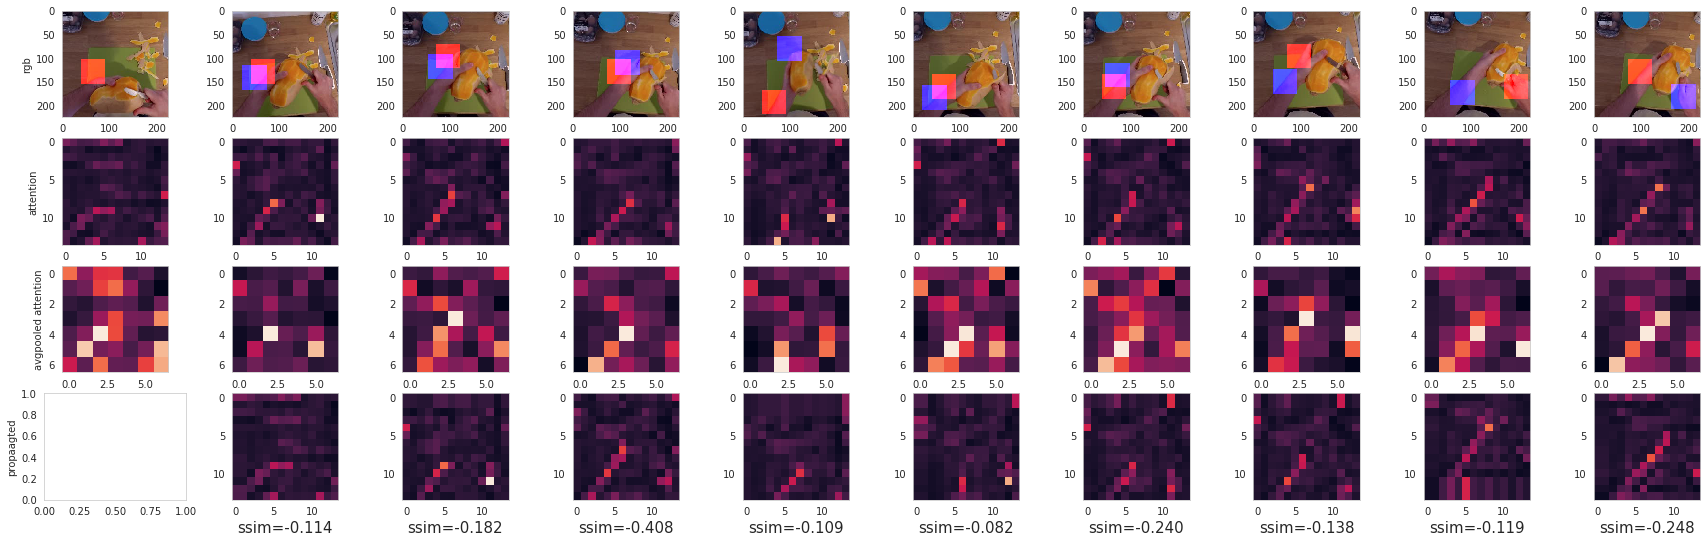

In [7]:
run_experiment(sample_id=64, w_size=51)